In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
from pathlib import Path
import datetime as dt
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import json
import csv
from matplotlib.ticker import FuncFormatter

def comma_formatter(x, pos):
    return f'{x:,.0f}'


In [3]:
H5BENCH_OUTPUT_DIR = Path("../raw/h5bench")

df_plot = (
    pl.concat(
        [
            pl.scan_csv(csv_file)
            .select(
                [
                    pl.col("metric"),
                    pl.col(" value").alias("value"),
                    pl.col(" unit").alias("unit"),
                ]
            )
            .with_columns(
                pl.col("value").str.strip_chars(),
                pl.col("unit").str.strip_chars(),
            )
            .pipe(
                lambda df: (
                    df.filter(pl.col("metric").is_in(["ranks", "observed rate"]))
                    .with_columns(
                        [
                            pl.when(pl.col("unit").str.contains("KB"))
                            .then(pl.col("value").cast(pl.Float64) * 2**10)
                            .when(pl.col("unit").str.contains("MB"))
                            .then(pl.col("value").cast(pl.Float64) * 2**20)
                            .when(pl.col("unit").str.contains("GB"))
                            .then(pl.col("value").cast(pl.Float64) * 2**30)
                            .when(pl.col("unit").str.contains("TB"))
                            .then(pl.col("value").cast(pl.Float64) * 2**40)
                            .otherwise(pl.col("value"))
                        ]
                    )
                    .select("metric", "value")
                    .collect()
                    .transpose(column_names="metric")
                    .hstack(
                        df.filter(pl.col("metric") == "operation")
                        .select(pl.col("value").alias("operation"))
                        .collect()
                    )
                )
            )
            .with_columns(
                pl.col("ranks").cast(pl.Int64),
                (pl.col("observed rate").cast(pl.Float64)).alias("bw"),
            )
            .select("operation", "ranks", "bw")
            for log_dir in H5BENCH_OUTPUT_DIR.glob("*")
            for csv_file in log_dir.glob("*.csv")
        ]
    )
    .group_by("operation", "ranks")
    .agg(pl.mean("bw"))
    .sort("operation", "ranks")
)
df_plot.head()

operation,ranks,bw
str,i64,f64
"""read""",16,3.4397e10
"""read""",32,6.6217e10
"""write""",16,1.1724e10
"""write""",32,2.1217e10


ranks,bw
i64,f64
16,11724.186976
32,21217.138442


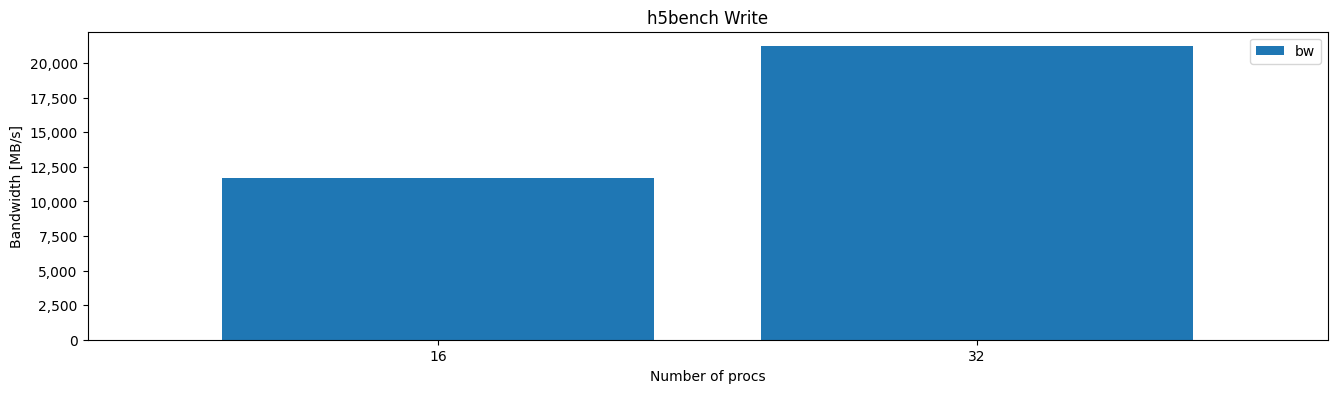

ranks,bw
i64,f64
16,34397.319332
32,66216.584544


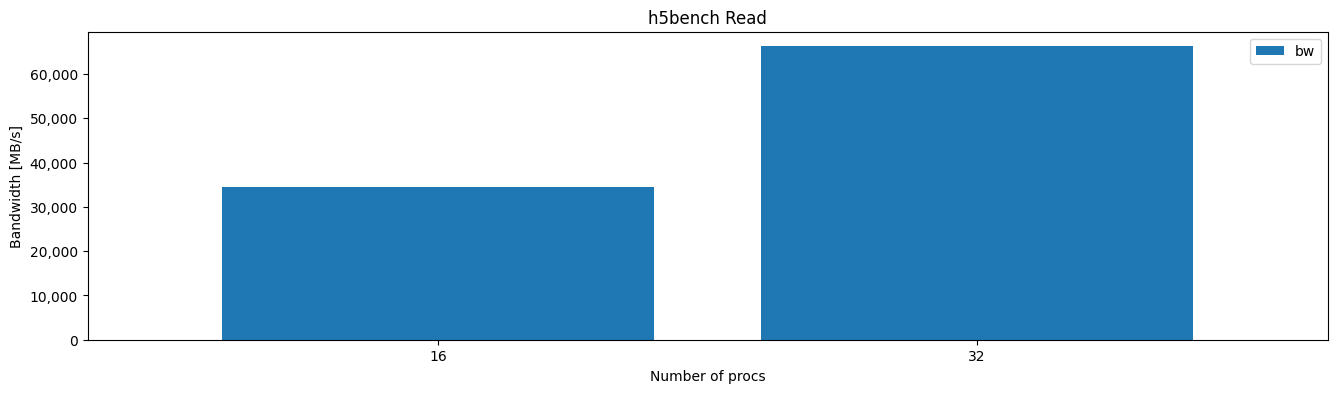

In [4]:
for ops in ["write", "read"]:
    fig = plt.figure(figsize=(16, 4), dpi=100)
    fig.patch.set_alpha(1)
    ax = (
        df_plot
        .filter(pl.col("operation") == ops)
        .select("ranks", "bw")
        .with_columns(bw=pl.col("bw") / 10**6)
        .pipe(lambda df: (display(df), df)[-1])
        .to_pandas()
        .set_index("ranks")
        .plot(
            ax=fig.add_subplot(),
            kind="bar",
            xlabel="Number of procs",
            ylabel="Bandwidth [MB/s]",
            legend=True,
            rot=0,
            width=0.8,
        )
        
    )
    ax.set_title(f"h5bench {ops.capitalize()}")
    ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))
    plt.show()